In [1]:
import config
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from operator import attrgetter
import datetime as dt
import seaborn as sns
import scipy.optimize
import numpy.typing as npt
from typing import Iterable, Generator, Sequence
from functools import partial
import json

In [2]:
def date_to_milliseconds(date: dt.datetime) -> float:
    return date.timestamp() * 1000

def milliseconds_to_date(milliseconds: float) -> dt.datetime:
    return dt.datetime.fromtimestamp(milliseconds / 1000)

def months_to_milliseconds(months: float) -> float:
    return months * config.MILLISECONDS_IN_MONTH

def milliseconds_to_months(milliseconds: float) -> float:
    return milliseconds / config.MILLISECONDS_IN_MONTH

def ceil_round(x: float, /, *, multiple: float) -> float:
    '''
    Raises
    ------
    ValueError: If `multiple` is zero.
    '''
    if multiple == 0:
        raise ValueError('Argument `multiple` must be non-zero.')
    
    return np.ceil(x / multiple) * multiple

def inclusive_range(start: float, end: float, step: float) -> npt.NDArray[np.float64]:
    '''Generate a numpy array representing a range of values from `start` to `end`, inclusive, with a specified `step` size. The resulting array includes the `end` value but may go over `end` if necessary to ensure inclusion based on the `step` size.

    Raises
    ------
    ValueError: If `start` is greater than `end` is zero.
    ValueError: If `step` is smaller than or equal to zero.
    '''
    if start > end:
        raise ValueError('Argument `start` cannot be greater than argument `end`.')

    if step <= 0:
        raise ValueError('Argument `step` must be strictly greater than zero.')

    size = np.ceil((end - start) / step) + 1
    inclusive_range_arr = start + step * np.arange(size)
    return inclusive_range_arr

In [3]:
def quarter_to_timestamp_milliseconds(quarter_str: str) -> float:
    quarter_index, year = map(int, quarter_str[1:].split())
    month = quarter_index * 3 - 2
    date = dt.datetime(year, month, 1)
    return date_to_milliseconds(date)

observed = pd.read_csv(config.DATA_DIR / 'facebook_quarterly_monthly_active_users.csv')
observed['timestamp_milliseconds'] = observed['quarter'].apply(quarter_to_timestamp_milliseconds)

In [4]:
Theta = tuple[float, float, float, float, float]

def forward_euler(theta: Theta, *, t_start, t_end, t_step):
    S0, I0, R0, alpha, beta = theta
    N = S0 + I0 + R0

    t_start_offset = 0
    t_end_offset = t_end - t_start
    t = inclusive_range(t_start_offset, t_end_offset, t_step)
    size = len(t)

    S = np.zeros(size)
    I = np.zeros(size)
    S[0] = S0
    I[0] = I0

    for n, _ in enumerate(t[:-1]):
        S[n + 1] = S[n] + t_step * (-alpha / N * S[n] * I[n])
        I[n + 1] = I[n] + t_step * (alpha / N * S[n] * I[n] - beta * I[n])

    t += t_start
    model = pd.DataFrame({
        'I': I,
        'timestamp_milliseconds': t,
    })
    return model

def forward_euler_milliseconds(theta: Theta, *, t_start_months, t_end_months, t_step_months):
    model_months = forward_euler(theta, t_start=t_start_months, t_end=t_end_months, t_step=t_step_months)
    model_milliseconds = model_months.rename(columns={'t': 'timestamp_milliseconds'})
    model_milliseconds['timestamp_milliseconds'] = model_milliseconds['timestamp_milliseconds'].apply(months_to_milliseconds)
    return model_milliseconds

def sum_squared_errors(theta: Theta) -> float:
    I_data = observed['MAU']
    t = observed['timestamp_milliseconds']

    time_options = {
        't_start_months': milliseconds_to_months(np.min(t)),
        't_end_months': milliseconds_to_months(np.max(t)),
        't_step_months': 1e-1,
    }
    I_estimate = forward_euler_milliseconds(theta, **time_options)
    
    I_interpolated = np.interp(t, I_estimate['timestamp_milliseconds'], I_estimate['I'])

    return np.sum((I_data - I_interpolated) ** 2)

# Nelder mead parameter optimisation

In [5]:
EPSILON = np.finfo(float).eps
WORLDWIDE_INTERNET_USERS_COUNT = config.FACEBOOK_SIR_CONSTANTS.N
THETA_BOUNDS = scipy.optimize.Bounds(lb=(0, 0, 0, EPSILON, EPSILON), ub=(WORLDWIDE_INTERNET_USERS_COUNT, WORLDWIDE_INTERNET_USERS_COUNT, WORLDWIDE_INTERNET_USERS_COUNT, np.inf, np.inf))

def is_within_bounds(vector: Sequence[float], bounds: scipy.optimize.Bounds) -> bool:
    lower_residuals, upper_residuals = bounds.residual(vector)
    return bool(np.all(lower_residuals >= 0) and np.all(upper_residuals >= 0))

is_theta_within_bounds = partial(is_within_bounds, bounds=THETA_BOUNDS)

def nelder_mead(x0: Theta) -> scipy.optimize.OptimizeResult:
    return scipy.optimize.minimize(fun=sum_squared_errors, x0=x0, method='nelder-mead', bounds=THETA_BOUNDS, options={
        'xatol': 1e-5,
        'fatol': 1e4,
        'maxiter': np.inf,
        'maxfev': np.inf,
        'disp': True,
    })

theta_intuitive: Theta = attrgetter('S0', 'I0', 'R0', 'alpha', 'beta')(config.FACEBOOK_SIR_CONSTANTS)
result = nelder_mead(x0=theta_intuitive)
theta_optimized = result.x

print(result)
print(f'{theta_optimized=}')

Optimization terminated successfully.
         Current function value: 34246166189697724.000000
         Iterations: 924
         Function evaluations: 1646
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3.4246166189697724e+16
             x: [ 3.444e+09  1.923e+09  6.993e+08  2.749e-02  4.581e-03]
           nit: 924
          nfev: 1646
 final_simplex: (array([[ 3.444e+09,  1.923e+09, ...,  2.749e-02,
                         4.581e-03],
                       [ 3.444e+09,  1.923e+09, ...,  2.749e-02,
                         4.581e-03],
                       ...,
                       [ 3.444e+09,  1.923e+09, ...,  2.749e-02,
                         4.581e-03],
                       [ 3.444e+09,  1.923e+09, ...,  2.749e-02,
                         4.581e-03]]), array([ 3.425e+16,  3.425e+16,  3.425e+16,  3.425e+16,
                        3.425e+16,  3.425e+16]))
theta_optimized=array([3.44400000e+09, 1.92296786e+09,

# Escaping local minima

In [6]:
def _tuple_sum(tuple1: tuple[float, ...], tuple2: tuple[float, ...]) -> tuple[float, ...]:
    return tuple(map(sum, zip(tuple1, tuple2)))

def _magnitude_to_directions(magnitude: float) -> tuple[float, float, float] | tuple[float]:
    if magnitude == 0:
        return (0,)
    else:
        return (-magnitude, 0, magnitude)

def _get_all_variation_vectors(axes_variations, variated_vectors_mutated_arr: list[tuple[float, ...]], partial_variation_vector=None):
    # if len(axes_variations) == 1:
    #     axis_variations = axes_variations[0]
        
    #     for variation in axis_variations:
    #         variation_vector = (*partial_variation_vector, variation)
    #         return variation_vector
    # else:
    #     axis_variations = axes_variations[0]
        
    #     for variation in axis_variations:
    #         variation_vector = (variation,) if partial_variation_vector is None else (*partial_variation_vector, variation)
    #         return helper(axes_variations[1:], variation_vector)
        
    axis_variations = axes_variations[0]
    
    for variation in axis_variations:
        variation_vector = (variation,) if (partial_variation_vector is None) else (*partial_variation_vector, variation)

        if len(axes_variations) == 1:
            variated_vectors_mutated_arr.append(variation_vector)

        if len(axes_variations) > 1:
            _get_all_variation_vectors(axes_variations[1:], variated_vectors_mutated_arr, variation_vector)

# FIXME: yield from + refactor
# TODO: example toevoegen uit tests
# TODO: test of initial_vector en axis_variation_magnitudes zelfde lengte hebben
def variate_vector(initial_vector: Sequence[float], axis_variation_magnitudes: Sequence[float]) -> Generator[tuple[float], None, None]:
    '''Generate a grid of variated vectors by applying all possible combinations of variations along each axis of `initial_vector`.
    The variations in a single axis of `initial_vector` consist of the negative, zero, and positive direction, where the magnitude
    of the direction is the value in `axis_variation_magnitudes`, with the index corresponding to the axis from `initial_vector`.
    The grid of variated vectors includes `initial_vector`.

    Parameters
    ----------
    `initial_vector`: The initial vector to which the variations are applied.

    `axis_variation_magnitudes`: Sequence where each element represents the magnitude of the directions for the variations in the axis
    of `initial_vector` with corresponding index. A magnitude of zero indicates no variation in the axis of `initial_vector` with
    corresponding index.

    Yields
    ------
    Variated vector of the generated grid.

    Raises
    ------
    ValueError: If any element in `axis_variation_magnitudes` is negative.
    '''
    if any(magnitude < 0 for magnitude in axis_variation_magnitudes):
        raise ValueError('Elements of argument `axis_variation_magnitudes` must be non-negative.')
    
    initial_vector_tuple = tuple(initial_vector)
    axis_directions_arr = list(map(_magnitude_to_directions, axis_variation_magnitudes))
    variation_vectors_mutated_arr = []
    _get_all_variation_vectors(axis_directions_arr, variation_vectors_mutated_arr)

    for variation_vector in variation_vectors_mutated_arr:
        yield _tuple_sum(initial_vector_tuple, variation_vector)

    # for ax1_variation in axes_variations[0]:
    #     for ax2_variation in axes_variations[1]:
    #         variation_vector = (ax1_variation, ax2_variation)
    #         yield tuple_sum(initial_vector_tuple, variation_vector)

    # def helper():
    #     try:
    #         axis_variations = next(iterator)

    #         for variation in axis_variations:
    #             yield 
    #     except StopIteration:
    #         pass

def converge_theta(theta: Theta, sum_of_squared_errors: float) -> tuple[Theta, float]:
    '''Hone in on minimum by iteratively rerunning Nelder-Mead on theta.'''

    current_best_theta = theta
    current_best_sum_of_squared_errors = sum_of_squared_errors
    has_theta_converged = False

    while not has_theta_converged:
        result = nelder_mead(x0=current_best_theta)
        new_theta = tuple(result.x)
        new_sum_of_squared_errors = result.fun

        if new_sum_of_squared_errors < current_best_sum_of_squared_errors:
            current_best_theta = new_theta
            current_best_sum_of_squared_errors = new_sum_of_squared_errors
            print('found new best theta from converging')
            continue

        has_theta_converged = True

    return current_best_theta, current_best_sum_of_squared_errors

AXIS_VARIATION_MAGNITUDES = (1e8, 1e8, 1e7, 1e-4, 1e-4)
current_best_theta = theta_intuitive
current_best_sum_of_squared_errors = sum_squared_errors(theta_intuitive)
is_theta_optimal = False

while not is_theta_optimal:
    result = nelder_mead(x0=current_best_theta)
    new_theta = tuple(result.x)
    new_sum_of_squared_errors = result.fun

    # Rerunning Nelder-Mead with the resulting theta as the new guess can give a different theta and with it, a new least squares error
    if new_sum_of_squared_errors < current_best_sum_of_squared_errors:
        current_best_theta = new_theta
        current_best_sum_of_squared_errors = new_sum_of_squared_errors

    # Variate current best theta in search of a theta with a reduced least squares error
    variated_thetas_boundless = variate_vector(current_best_theta, AXIS_VARIATION_MAGNITUDES)
    variated_thetas = np.array(list(filter(is_theta_within_bounds, variated_thetas_boundless)))
    sum_of_squared_errors_arr = np.array(list(map(sum_squared_errors, variated_thetas)))
    min_sum_of_squared_errors_index = np.argmin(sum_of_squared_errors_arr)
    new_sum_of_squared_errors = sum_of_squared_errors_arr[min_sum_of_squared_errors_index]
    new_theta = tuple(variated_thetas[min_sum_of_squared_errors_index])

    if new_sum_of_squared_errors < current_best_sum_of_squared_errors:
        current_best_theta = new_theta
        current_best_sum_of_squared_errors = new_sum_of_squared_errors
        print('found new best theta from variating theta')
        continue

    # None of the variated thetas have a reduced least squares error, so converge current best theta
    current_best_theta, current_best_sum_of_squared_errors = converge_theta(current_best_theta, current_best_sum_of_squared_errors)

    is_theta_optimal = True

theta_optimized = current_best_theta
optimized_sum_of_squared_errors = current_best_sum_of_squared_errors
optimized_parameters = {
    'theta': theta_optimized,
    'sum_of_squared_errors': optimized_sum_of_squared_errors,
}

print(f'{theta_optimized=}')
print(f'{optimized_sum_of_squared_errors=}')

with open(config.RESULTS_DIR / 'basic_facebook_sir_optimized_parameters.json', 'w') as file:
    json.dump(optimized_parameters, file, indent=config.JSON_INDENT)

Optimization terminated successfully.
         Current function value: 34246166189697724.000000
         Iterations: 924
         Function evaluations: 1646
Optimization terminated successfully.
         Current function value: 34246166189697724.000000
         Iterations: 171
         Function evaluations: 445
theta_optimized=(3443999999.998786, 1922967859.886512, 699252452.9397621, 0.02748682735904053, 0.004580848786851357)
optimized_sum_of_squared_errors=3.4246166189697724e+16


In [7]:
time_options = {
    't_start_months': milliseconds_to_months(np.min(observed['timestamp_milliseconds'])),
    't_end_months': milliseconds_to_months(np.max(observed['timestamp_milliseconds'])),
    't_step_months': 1e-1,
}
model_intuitive = forward_euler_milliseconds(theta_intuitive, **time_options)
model_optimized = forward_euler_milliseconds(theta_optimized, **time_options)

# Parameter fit plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


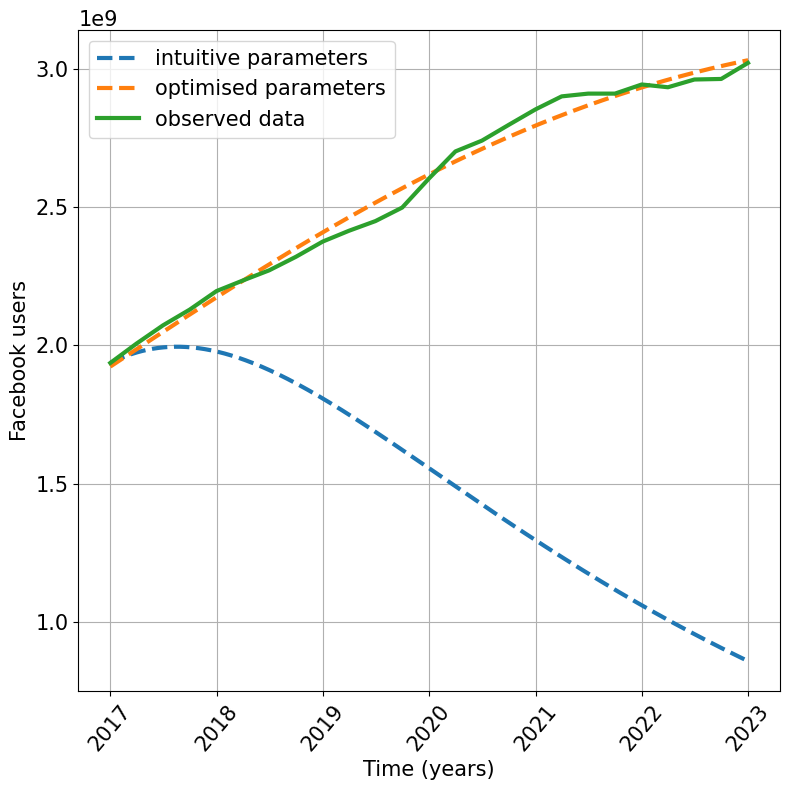

In [8]:
FIGURE_WIDTH = 8
FIGURE_HEIGHT = 8
LINEWIDTH = 3
FONTSIZE = 15

MODEL_LINESTYLE = 'dashed'
OBSERVED_LINESTYLE = 'solid'

plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.legend(fontsize=FONTSIZE)
plt.grid(True)

plt.plot(model_intuitive['timestamp_milliseconds'], model_intuitive['I'], label='intuitive parameters', linewidth=LINEWIDTH, linestyle=MODEL_LINESTYLE)
plt.plot(model_optimized['timestamp_milliseconds'], model_optimized['I'], label='optimised parameters', linewidth=LINEWIDTH, linestyle=MODEL_LINESTYLE)
plt.plot(observed['timestamp_milliseconds'], observed['MAU'], label='observed data', linewidth=LINEWIDTH, linestyle=OBSERVED_LINESTYLE)

def timestamp_milliseconds_to_year(timestamp_milliseconds: float) -> int:
    date = milliseconds_to_date(timestamp_milliseconds)
    return date.year

def year_to_timestamp_milliseconds(year: int) -> float:
    date = dt.datetime(year, 1, 1)
    return date_to_milliseconds(date)

all_timestamps_milliseconds = np.concatenate([
    model_intuitive['timestamp_milliseconds'], 
    model_optimized['timestamp_milliseconds'], 
    observed['timestamp_milliseconds'],
])
min_year = timestamp_milliseconds_to_year(np.min(all_timestamps_milliseconds))
max_year = timestamp_milliseconds_to_year(np.max(all_timestamps_milliseconds))
years = np.arange(min_year, max_year + 1)
xticks = list(map(year_to_timestamp_milliseconds, years))
xlabels = years

ax = plt.gca()
ax.set_xticks(xticks, xlabels, rotation=50)
ax.yaxis.offsetText.set_fontsize(FONTSIZE)

plt.xlabel('Time (years)', fontsize=FONTSIZE)
plt.ylabel('Facebook users', fontsize=FONTSIZE)
plt.legend(loc='best', fontsize=FONTSIZE)

plt.tight_layout()
plt.savefig(config.FIGURES_DIR / 'basic_facebook_sir_model_parameter_optimization.svg')
plt.show()